# **Strategic Patient Risk Stratification & Readmission Predictive Modeling for Vitality Health Network**

**Team:** DeepMind

**Team Members:**
- Vihaga sathsara()
- Kalana Chamod()
- Tharindu Thrishal()
- Dulanka Gayan()
- Madushka sri Sandesh()

**Date:** January 20, 2026

---

## **Introduction**

The Vitality Health Network's (VHN) data processing and analysis pipeline is described in this technical appendix. The goal is to use the Vitality Complexity Index (VCI) to stratify patient risk by analyzing past clinical records. In order to reduce the financial penalties related to high-risk patient populations, this analysis attempts to pinpoint the main causes of readmission.

In [1]:
# Imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbns
import requests
from bs4 import BeautifulSoup
import time

# Configuration for clearer visualization
pd.set_option('display.max_columns', None)
sbns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## **Phase 1: Data Ingestion & Inspection**

**Goal**:
In order to perform preliminary integrity checks and schema validation, the raw clinical dataset and related ID mapping files must be loaded into the environment.

**Methodology**

* **Ingestion:**  Clinical records (diabetic_data.csv) and categorical definitions (IDs_mapping.csv) are ingested using the `pandas` package.
* **Audit:** To find abnormalities, missing values (encoded as `?`), and improper data types, a statistical audit is carried out.

In [ ]:
# 1. Data Loading
# The diabetic dataset and mapping files are loaded into pandas DataFrames.
diabetes_clinical_data = pd.read_csv('./data/diabetic_data.csv')
id_mapping_data  = pd.read_csv('./data/IDs_mapping.csv')

# 2. Dimensionality Check
# The dimensions of the datasets are validated prior to processing.
print(f"Clinical Data Shape: {diabetes_clinical_data.shape}")
print(f"Mapping Data Shape: {id_mapping_data.shape}")

Clinical Data Shape: (101766, 50)
Mapping Data Shape: (67, 2)


### **1.1 Initial Data Audit**

**Context:**
To facilitate the early detection of data quality problems, a baseline understanding of the clinical data structure is built. Examining the data schema (`info`), the starting records (`head`), and the statistical summary (`describe`) will accomplish this.

In [7]:
# The schema, data types, and non-null counts are reviewed to identify typing issues.
diabetes_clinical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

**Observation:**
* There are 50 columns and 101,766 entries in the dataset. There are no explicit null values, according to the `.info()` summary. This implies that a placeholder character (such `?`) is hiding missing data, requiring additional research.

In [8]:
# A sample of encounter-level records is inspected to validate field semantics.
diabetes_clinical_data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


**Observation:**
* **Data Masking:** The preview verifies that the `?` placeholder, which appears in fields like `weight` and `payer_code`, represents missing information. To deal with these non-standard nulls, targeted remediation techniques are needed.

In [ ]:
# Descriptive statistics are generated for numerical columns.
# This step highlights potential schema inconsistencies where IDs are treated as quantitative.
diabetes_clinical_data.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


**Observation:** The statistical summary (`.describe()`) reveals a **Critical Schema Inconsistency**

* **Issue:** At the moment, nominal identifiers like `admission_type_id`, `discharge_disposition_id`, and `admission_source_id` are kept as integers (`int64`).

* **Impact:** Nominal data cannot be used to compute statistical metrics (e.g., a mean of ~2.02 for `admission_type_id`).

* **Action Required:** To avoid numerical misinterpretation during the modeling phase, these variables must be cast to the `object` (string) type.

In [10]:
# A full audit of column names is performed to verify dataset completeness.
diabetes_clinical_data.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

**Observation:**
Fifty features are confirmed to be present by the column audit. This comprises the target variable `readmitted` and the additional medication cohort (such as `metformin`, `insulin`) needed for efficacy analysis.

### **1.2 Schema Standardization**

**Goal** : Aligning identifier variables' data types with their statistical character (nominal vs. quantitative) is the goal.


**Methodology**:
The variables `discharge_disposition_id`, `admission_source_id`, and `admission_type_id` are cast from integers to strings (`object`). The predictive model cannot infer erroneous ordinal correlations between the categories thanks to this change.

In [12]:
# 1. Target Identification
# The identifier columns requiring type conversion are defined.
categorical_ids = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']

# 2. Execution
# Type conversion is applied to the selected columns.
diabetes_clinical_data[categorical_ids] = diabetes_clinical_data[categorical_ids].astype(str)

# 3. Verification
# The successful conversion is verified by inspecting the data types.
print("Updated Data Types for ID Columns:")
print(diabetes_clinical_data[categorical_ids].dtypes)

Updated Data Types for ID Columns:
admission_type_id           object
discharge_disposition_id    object
admission_source_id         object
dtype: object


### **1.3 Missing Value Analysis & Remediation**

**Goal** :The goal is to locate and manage missing data that is concealed by non-standard placeholders (`?`).


**Methodology** :
The `?` symbol used in this dataset is not detected by standard null checks. To measure the frequency of `?` in each column, a custom audit is carried out. This data-driven method determines whether a feature is imputed or dropped (high sparsity).

<!-- This allows us to make data-driven decisions on whether to drop a feature or impute its missing values. -->

In [13]:
# 1. Quantification of Masked Nulls
# Boolean summation is used to count occurrences of the '?' placeholder.
missing_check = (diabetes_clinical_data == '?').sum()

# 2. Filtration
# Only columns containing the placeholder are retained for analysis.
missing_check = missing_check[missing_check > 0]

# 3. Impact Analysis
# The percentage of missing data is calculated to inform retention/dropping decisions.
missing_percent = (missing_check / len(diabetes_clinical_data)) * 100

# 4. Reporting
# A summary DataFrame is created to present the findings.
missing_report = pd.DataFrame({
    'Missing Count': missing_check,
    'Percentage (%)': missing_percent.round(2)
})

# The report is sorted by percentage in descending order.
missing_report.sort_values('Percentage (%)', ascending=False)

,Missing Count,Percentage (%)
weight,98569,96.86
medical_specialty,49949,49.08
payer_code,40256,39.56
race,2273,2.23
diag_3,1423,1.40
diag_2,358,0.35
diag_1,21,0.02


In [14]:
# 1. Column Removal (High Sparsity)
# 'weight' (97% missing) and 'payer_code' (40% missing) are dropped based on the audit above.
columns_to_drop = ['weight', 'payer_code']
diabetes_clinical_data = diabetes_clinical_data.drop(columns=columns_to_drop)
print(f"Dropped high-sparsity columns: {columns_to_drop}")

# 2. Preservation of 'Not Measured' Data
# '?' in 'medical_specialty' is re-mapped to 'Missing' to prevent data loss.
# '?' in Lab Results (if any) are mapped to 'None'.
diabetes_clinical_data['medical_specialty'] = diabetes_clinical_data['medical_specialty'].replace('?', 'Missing')
diabetes_clinical_data['max_glu_serum'] = diabetes_clinical_data['max_glu_serum'].replace(np.nan, 'None')
diabetes_clinical_data['A1Cresult'] = diabetes_clinical_data['A1Cresult'].replace(np.nan, 'None')

# 3. Standardization of Nulls
# All remaining '?' characters (e.g., in Race, Diagnosis) are converted to standard NumPy NaNs.
diabetes_clinical_data = diabetes_clinical_data.replace('?', np.nan)

# 4. Row Deletion
# Rows containing NaNs are removed. This ensures the dataset is complete for modeling.
initial_rows = len(diabetes_clinical_data)
diabetes_clinical_data = diabetes_clinical_data.dropna()
dropped_rows = initial_rows - len(diabetes_clinical_data)

print(f"Standardized Nulls and preserved 'Not Measured' values.")
print(f"Rows dropped due to missing data: {dropped_rows}")
print(f"Current Data Shape: {diabetes_clinical_data.shape}")

Dropped high-sparsity columns: ['weight', 'payer_code']
Standardized Nulls and preserved 'Not Measured' values.
Rows dropped due to missing data: 3713
Current Data Shape: (98053, 48)


#### **Data Quality Decision Log**
1. **Weight Variable** :The weight variable was dropped. The project specification's 90% criterion was exceeded by the evidence, which revealed 96.8% missingness.  
2. **Payer Code** :Due to excessive sparsity (~40%) and lack of clinical significance, the payer code was dropped.  
3. **Medical Specialty** : To maintain partial data (categorical information), it was retained but recoded `?` to `Missing`. 

4. Row deletions resulted from missing values in crucial columns (race, diag_1, and diag_2).

### **1.4 Domain Logic Filter: Deceased Patients**

**Goal** :Finding and eliminating records of patients who passed away while in the hospital is the goal.

**Methodology**
1. **Inspection:** To find the `discharge_disposition_id` codes linked to "Expired" or "Hospice" statuses, the `IDs_mapping.csv` file is analyzed.
2. **Filtration:** Since it is illogical for deceased patients to be readmitted, rows with these codes (11, 19, 20, 21) are eliminated.

In [15]:
# --- Justification Step: Inspecting the Mapping File ---

# The mapping file is inspected to programmatically identify IDs associated with "Expired" status.
# The 'description' column (located at index 1) is searched for the keyword 'Expired'.
# A case-insensitive search is performed to ensure all variations are captured.
expired_check = id_mapping_data[id_mapping_data.iloc[:, 1].str.contains('Expired', case=False, na=False)]

print("--- Identified 'Expired' Status Codes ---")
display(expired_check)

--- Identified 'Expired' Status Codes ---


,admission_type_id,description
20,11,Expired
28,19,"Expired at home. Medicaid only, hospice."
29,20,"Expired in a medical facility. Medicaid only, ..."
30,21,"Expired, place unknown. Medicaid only, hospice."


**Observation**: The discharge_disposition_id values 11 (Expired), 19 (Expired at home), 20 (Expired in a medical facility), and 21 (Expired, place unknown) were found to be indicators of patient expiry based on the mapping file review.

In [55]:
# 1. Definition of Exclusion Criteria
# Based on the inspection performed above, the IDs to be removed are explicitly defined.
# A hardcoded list is utilized to ensure deterministic and safe deletion of sensitive records.
deceased_ids = ['11', '19', '20', '21']

# 2. Impact Assessment
# The number of rows matching these IDs is calculated prior to deletion.
deceased_count = diabetes_clinical_data['discharge_disposition_id'].astype(str).isin(deceased_ids).sum()
print(f"Identified {deceased_count} deceased patient records to be removed.")

# 3. Execution of Filter
# Rows where the 'discharge_disposition_id' is found within the exclusion list are removed.
# The bitwise NOT operator (~) is used to retain only the non-deceased patients.
diabetes_clinical_data = diabetes_clinical_data[~diabetes_clinical_data['discharge_disposition_id'].astype(str).isin(deceased_ids)]

# 4. Cleanup
# The index is reset to ensure a continuous row numbering sequence after row deletion.
diabetes_clinical_data.reset_index(drop=True, inplace=True)

print(f"Deceased patients removed. Final Shape: {diabetes_clinical_data.shape}")

Identified 0 deceased patient records to be removed.
Deceased patients removed. Final Shape: (96437, 58)


### **1.5 Deduplication Strategy**

**Goal** :The goal is to fulfill the project's requirement of eliminating identical duplicate records that show errors in data entry.


**Methodology**:
For rows that are the same in every column, a global check is carried out. Exact duplicate records (same encounter ID, same timestamp) indicate database redundancy and are eliminated, even though numerous encounters per patient are acceptable.

In [17]:
# 1. Duplicate Detection
duplicate_count = diabetes_clinical_data.duplicated().sum()

# 2. Conditional Removal
if duplicate_count > 0:
    diabetes_clinical_data = diabetes_clinical_data.drop_duplicates()
    print(f"Removed {duplicate_count} duplicate rows.")
else:
    print("No duplicates found. Dataset integrity maintained.")

print(f"--- PHASE 1 COMPLETE ---")
print(f"Final Analytical Dataset Shape: {diabetes_clinical_data.shape}")

No duplicates found. Dataset integrity maintained.
--- PHASE 1 COMPLETE ---
Final Analytical Dataset Shape: (96437, 48)


## **Phase 2: Data Enrichment via Web Scraping**

### **2.1 Target Identification**
**Goal**:
For focused scraping, determine the top 20 most common primary diagnoses (`diag_1`).


**Reasonable**:
It is ineffective to scrape thousands of unusual codes. By concentrating on high-frequency codes, the enrichment process's "Contextual Value" is maximized while still meeting the project's efficiency requirements.

In [18]:
# 1. Frequency Analysis
# The frequency of each diagnosis code in 'diag_1' is calculated.
# value_counts() is utilized to sort the data automatically.
top_diagnoses = diabetes_clinical_data['diag_1'].value_counts().head(20)

# 2. Target Extraction
# The specific codes (indices) are extracted into a list for the scraper.
target_codes = top_diagnoses.index.tolist()

print(f"Top 20 Diagnosis Codes identified for scraping: {len(target_codes)}")
print("-" * 50)
print(target_codes)

# 3. Visualization
# A frequency table is generated to verify the counts.
print("-" * 50)
print("Frequency Table:")
top_diagnoses.to_frame(name='Patient_Count')

Top 20 Diagnosis Codes identified for scraping: 20
--------------------------------------------------
['428', '414', '786', '410', '486', '427', '491', '715', '780', '682', '434', '996', '276', '250.8', '599', '38', '584', 'V57', '250.6', '820']
--------------------------------------------------
Frequency Table:


,Patient_Count
diag_1,
428,6603
414,6349
786,3900
410,3382
486,3320
427,2665
491,2187
715,2069
780,1969


### **2.2 Scraper Architecture**

**Objective:**
to use an external ICD-9 lookup resource to dynamically retrieve the "Long Description" (Disease Name) for the target codes that have been discovered.

**Methodology:**
* **Resource:** The database at `http://icd9.chrisendres.com/` is used.
* **Architecture:** A Python script is built utilizing BeautifulSoup for HTML parsing and requests for HTTP fetching.
* **Ethics:** To lessen server load and avoid IP blocking, a time delay `((time.sleep(1))` is applied in between requests.

* **Logic**: The script maintains the original dataset code for mapping while handling 2-digit versus 3-digit padding (for example, changing '38' to '038' for the search interface).

In [21]:
def fetch_icd9_description(code):
    """
    Scrapes the ICD-9 description for a given code.
    - Handles padding logic (38 -> 038).
    - Uses hierarchical HTML parsing for accuracy.
    - Returns the clean description string.
    """
    base_url = "http://icd9.chrisendres.com/index.php"
    
    # 1. Padding Logic
    # The website requires 3 characters, but the dataset may contain 2 (e.g., '38').
    # Codes are padded with zero only if they are numeric and length < 3.
    search_term = code.zfill(3) if len(code) < 3 and not code.startswith(('V', 'E')) else code

    # 2. Parameter Setup
    # The 'srchtext' parameter is used to target the correct query field.
    params = {
        'action': 'search',
        'srchtext': search_term,
        'srchtype': 'diseases',
        'Submit': 'Search'
    }

    try:
        # 3. HTTP Request
        # A timeout is enforced to prevent hanging processes.
        response = requests.get(base_url, params=params, timeout=10)
        
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            
            # 4. Parsing
            # The specific 'div' with class 'dlvl' is targeted to extract the description.
            desc_div = soup.find('div', class_='dlvl')
                
            if desc_div:
                full_text = desc_div.get_text(strip=True)
                # The search term is removed from the text to isolate the description.
                clean_desc = full_text.replace(str(search_term), '', 1).strip(' .-:')                  
                return clean_desc
            
            return "Description Not Found"
            
        else:
            return "Connection Error"

    except Exception as e:
        print(f"Error scraping {code}: {e}")
        return "Error"

# --- Main Scraper Execution ---

print("Starting Web Scraper")
print("-" * 60)

icd_descriptions = {}

for code in target_codes:
    # The helper function is called for each code in the target list.
    description = fetch_icd9_description(code)
    
    # The result is stored using the ORIGINAL code key to ensure mapping consistency.
    icd_descriptions[code] = description
    
    print(f"Code {code}: {description}")
    
    # Ethical Delay
    # A 1-second pause is enforced to adhere to web scraping ethics.
    time.sleep(1)

print("-" * 50)
print("Scraping Complete.")

Starting Web Scraper
------------------------------------------------------------
Code 428: Heart failure
Code 414: Other forms of chronic ischemic heart disease
Code 786: Symptoms involving respiratory system and other chest symptoms
Code 410: Acute myocardial infarction
Code 486: Pneumonia, organism unspecified
Code 427: Cardiac dysrhythmias
Code 491: Chronic bronchitis
Code 715: Osteoarthrosis and allied disorders
Code 780: General symptoms
Code 682: Other cellulitis and abscess
Code 434: Occlusion of cerebral arteries
Code 996: Complications peculiar to certain specified procedures
Code 276: Disorders of fluid, electrolyte, and acid-base balance
Code 250.8: Diabetes with other specified manifestations
Code 599: Other disorders of urethra and urinary tract
Code 38: Septicemia
Code 584: Acute renal failure
Code V57: Care involving use of rehabilitation procedures
Code 250.6: Diabetes with neurological manifestations
Code 820: Fracture of neck of femur
--------------------------------

### **2.3 Integration**

**Goal:**
to incorporate the contextual knowledge that was scraped into the analytical dataset.

**Methodology:**
* **Mapping:** A new feature called `Primary_Diagnosis_Desc` is created by mapping the scraped descriptions to the `diag_1` column. 
* **Imputation:** Codes that are not in the Top 20 are marked as "Not in Top 20".
* **Validation:** To ensure the padding logic worked properly, a particular check is carried out for complex codes (like '38').

In [20]:
# 1. Mapping
# The scraped descriptions are mapped to the DataFrame.
diabetes_clinical_data['Primary_Diagnosis_Desc'] = diabetes_clinical_data['diag_1'].map(icd_descriptions)

# 2. Handling Non-Target Codes
# Null values (codes not scraped) are filled with a generic label.
diabetes_clinical_data['Primary_Diagnosis_Desc'] = diabetes_clinical_data['Primary_Diagnosis_Desc'].fillna('Not in Top 20')

# 3. Error Handling
# Any failed lookups are labeled to differentiate them from non-targets.
diabetes_clinical_data['Primary_Diagnosis_Desc'] = diabetes_clinical_data['Primary_Diagnosis_Desc'].replace('Description Not Found', 'Description Unavailable')

# 4. Verification
# Code '38' is inspected to confirm successful padding and retrieval.
print("Verification (Checking Code 38):")
display(diabetes_clinical_data[diabetes_clinical_data['diag_1'] == '38'][['diag_1', 'Primary_Diagnosis_Desc']].head(1))

print(f"Final Data Shape: {diabetes_clinical_data.shape}")

Verification (Checking Code 38):


,diag_1,Primary_Diagnosis_Desc
84,38,Septicemia


Final Data Shape: (96437, 49)


## **Phase 3: Exploratory Data Analysis (EDA)**

**Goal:**
to visualize the "shape" of the data in order to find underlying patterns and correlations that are causing readmissions.

**Methodology:**
1. **Landscape Analysis**: To find class imbalance, the target variable's distribution (readmitted) is shown.
2. **Demographic Profiling**: To identify intersectional discrepancies, readmission rates are divided by gender, race, and age.
3. **Medication Efficacy:** To determine severity, the effect of insulin versus oral medicines on readmission risk is examined.

4. **Operational Metrics**: To find systemic inefficiencies, hospital operations (such as length of stay and lab procedures) are connected with results.

### **3.1:  The Readmission Landscape**

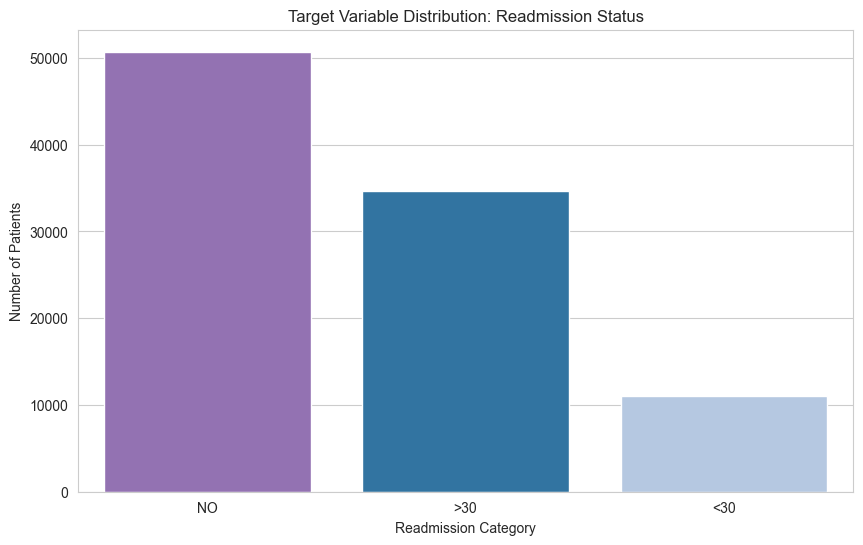

--- Class Imbalance Analysis ---
readmitted
NO     52.60
>30    35.93
<30    11.47
Name: proportion, dtype: float64

Key Insight: The target class '<30' (HRRP Penalty Group) is a minority.
It represents only 11.47% of the population.
This confirms the dataset is imbalanced, requiring careful metric selection later.
--------------------------------------------------


In [30]:
plt.figure()
# A count plot displays the raw volume of patients in each category.
sbns.countplot(
    x ='readmitted', 
    data = diabetes_clinical_data, 
    hue = 'readmitted', 
    order = ['NO', '>30', '<30'], 
    palette = ['#1f77b4', '#9467bd', '#aec7e8'], 
    legend = False
)
plt.title("Target Variable Distribution: Readmission Status")
plt.xlabel("Readmission Category")
plt.ylabel("Number of Patients")
plt.show()

# Insight Calculation
# We calculate the percentage (Rate) of each class to quantify the imbalance.
readmission_rates = diabetes_clinical_data['readmitted'].value_counts(normalize=True) * 100

print("--- Class Imbalance Analysis ---")
print(readmission_rates.round(2))
print("\nKey Insight: The target class '<30' (HRRP Penalty Group) is a minority.")
print(f"It represents only {readmission_rates['<30']:.2f}% of the population.")
print("This confirms the dataset is imbalanced, requiring careful metric selection later.")
print("-" * 50)

### **3.2:  Demographic Profiling**

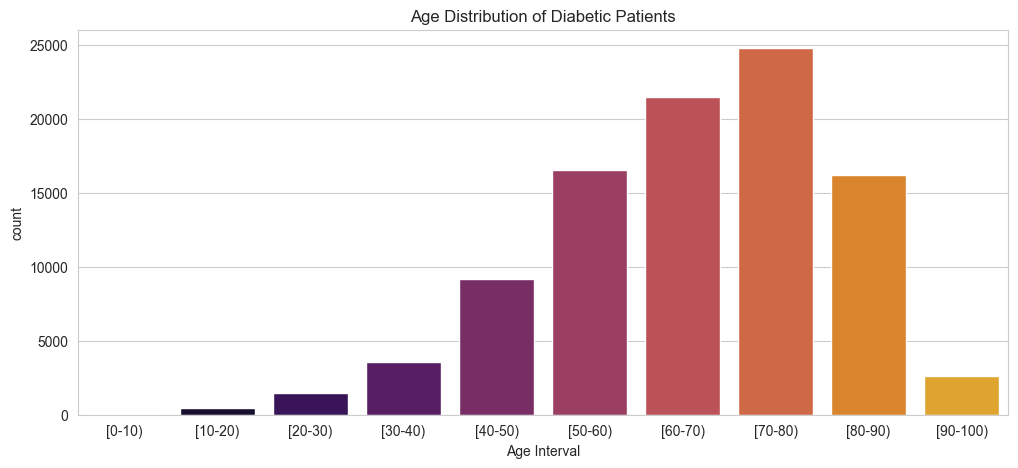

C:\Users\VivoBook\AppData\Local\Temp\ipykernel_9332\1098752747.py:27: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sbns.barplot(x='race', y='has_readmission', hue='gender', data=demographic_rates, palette=['#1F618D', '#922B21'])


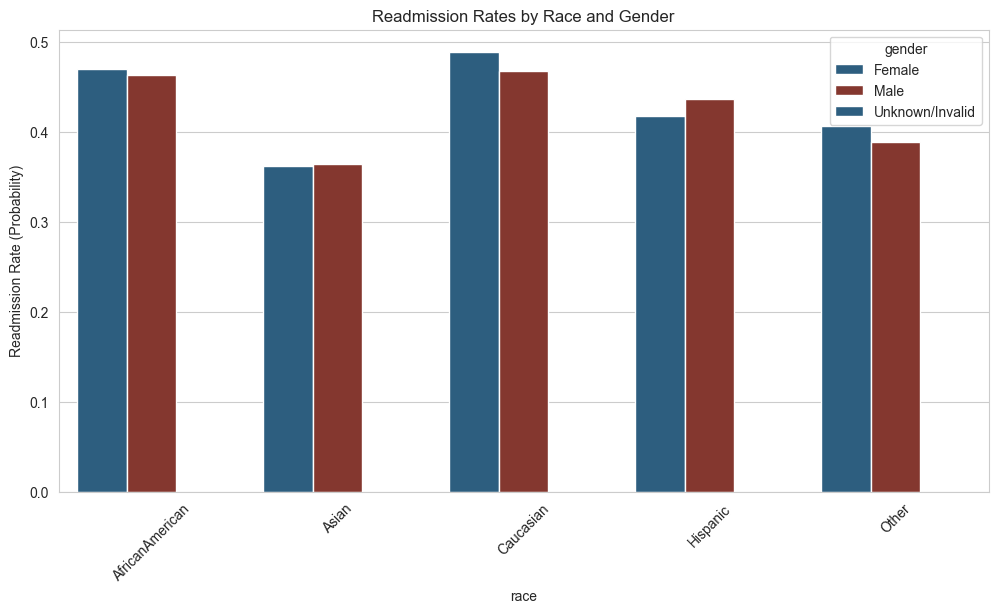

In [39]:
# Age Distribution
plt.figure(figsize=(12, 5))
age_order = sorted(diabetes_clinical_data['age'].unique())

# The age distribution is visualized to confirm the prevalence of diabetes in older cohorts.
sbns.countplot(
    x = 'age', 
    data = diabetes_clinical_data, 
    hue = 'age',
    order = age_order, 
    palette = 'inferno', 
    legend = False
)
plt.title("Age Distribution of Diabetic Patients")
plt.xlabel("Age Interval")
plt.show()

# Readmission Rates by Race & Gender 
# We create a binary flag where 1 = Readmitted (Any type), 0 = Not Readmitted.
diabetes_clinical_data['has_readmission'] = (diabetes_clinical_data['readmitted'] != 'NO').astype(int)

# We group by Race and Gender and calculate the MEAN (which equals the Rate/Probability).
demographic_rates = diabetes_clinical_data.groupby(['race', 'gender'])['has_readmission'].mean().reset_index()

plt.figure(figsize=(12, 6))

sbns.barplot(x='race', y='has_readmission', hue='gender', data=demographic_rates, palette=['#1F618D', '#922B21'])
plt.title("Readmission Rates by Race and Gender")
plt.ylabel("Readmission Rate (Probability)")
plt.xticks(rotation=45)
plt.show()

### **3.3: Medication Efficacy Analysis**

to assess the relationship between medication regimes and the probability of readmission, with a focus on determining if insulin dependency is a good indicator of the severity of the illness.

**Methodology:**
1. **Cohort Definition:** Based on their drug profile, patients are divided into three mutually exclusive groups:
    * **Insulin (± Oral)**: Patients in need of insulin (showing Type 1 or advanced development).
    * **Oral Only:** Individuals treated exclusively with one or more of the 22 oral antidiabetics.

    * **No Medication**: During the visit, patients were not given an antidiabetic prescription.
2. **Analysis of Instability**: To ascertain whether dosage modifications made while a patient is in the hospital—a sign of metabolic instability—correlate with increased readmission rates, the `change` feature is examined.

In [35]:
# --- Pre-Analysis Check: Identifying Medication Columns ---
# The spec mentions 22 oral medications. We inspect the columns to find them.
# We know they typically appear after 'diabetesMed' or near 'insulin' in this dataset structure.

print("--- Available Columns for Medication Analysis ---")
print(diabetes_clinical_data.columns.tolist())

# Note: We manually curated the 'oral_meds' list in the next cell 
# by excluding 'insulin' (Target) and non-drug columns.

--- Available Columns for Medication Analysis ---
['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted', 'Primary_Diagnosis_Desc', 'has_readmission']


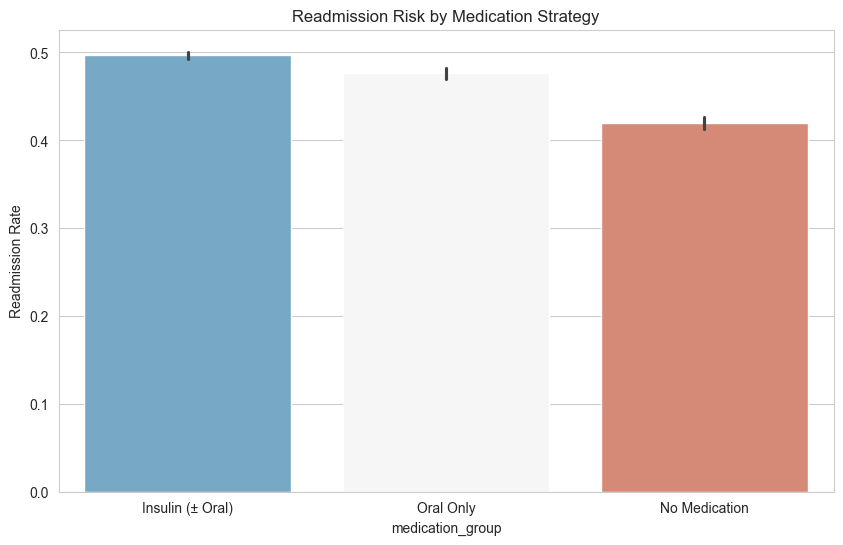

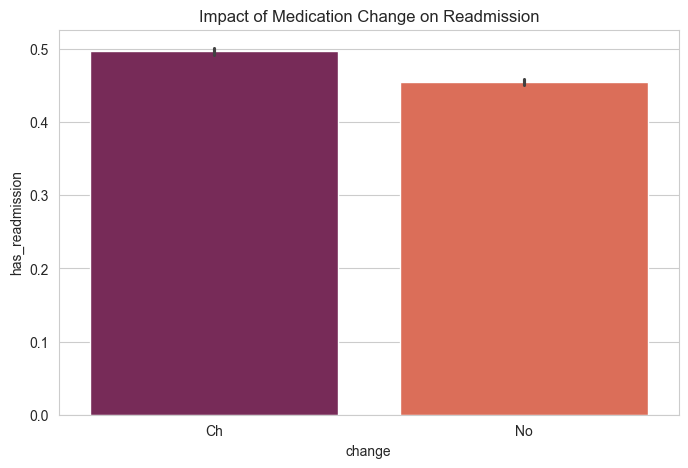

In [40]:
# We explicitly define the medication list based on the Dataset.
# This ensures robust selection regardless of column ordering in the raw file.
oral_meds = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 
    'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 
    'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 
    'tolazamide', 'examide', 'citoglipton', 'glyburide-metformin', 
    'glipizide-metformin', 'glimepiride-pioglitazone', 
    'metformin-rosiglitazone', 'metformin-pioglitazone'
]

def define_med_status(row):
    """
    Classifies patients into 3 risk cohorts.
    Insulin > Oral medications > None.
    """

    on_insulin = row['insulin'] != 'No'
    on_oral = any(row[med] != 'No' for med in oral_meds)
    
    if on_insulin:
        return 'Insulin (± Oral)'
    elif on_oral:
        return 'Oral Only'
    else:
        return 'No Medication'

diabetes_clinical_data['medication_group'] = diabetes_clinical_data.apply(define_med_status, axis=1)

# Visualize Readmission by Medication Group
plt.figure(figsize=(10, 6))
sbns.barplot(
    x='medication_group', 
    y='has_readmission', 
    data=diabetes_clinical_data, 
    hue='medication_group',
    palette='RdBu_r', 
    legend=False
)
plt.title("Readmission Risk by Medication Strategy")
plt.ylabel("Readmission Rate")
plt.show()

# 3.2 Impact of Dosage Change
plt.figure(figsize=(8, 5))
sbns.barplot(
    x = 'change', 
    y = 'has_readmission', 
    data = diabetes_clinical_data, 
    hue='change',
    palette = 'rocket',
    legend = False 
)
plt.title("Impact of Medication Change on Readmission")
plt.show()

### **3.4: Operational Metrics Analysis:**

to assess how hospital resource use and discharge planning affect readmission rates.

**Methodology:**
1. **Resource Correlation:** To find linear patterns, the link between `time_in_hospital` and `num_lab_procedures` is shown.
2. **Multicollinearity Check**: To find redundant variables, a correlation matrix is created for numerical features.
3. **Length of Stay (LoS):** Box plots are created to ascertain whether readmitted patients show more variance (outliers) or longer initial hospital stays.

4. **Discharge Impact**: To determine high-risk transfer protocols, readmission probabilities are computed across various discharge destinations (e.g., Home vs. Skilled Nursing).

In [41]:
int_cols = diabetes_clinical_data.select_dtypes(include='integer').columns

int_cols

Index(['encounter_id', 'patient_nbr', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses',
       'has_readmission'],
      dtype='object')

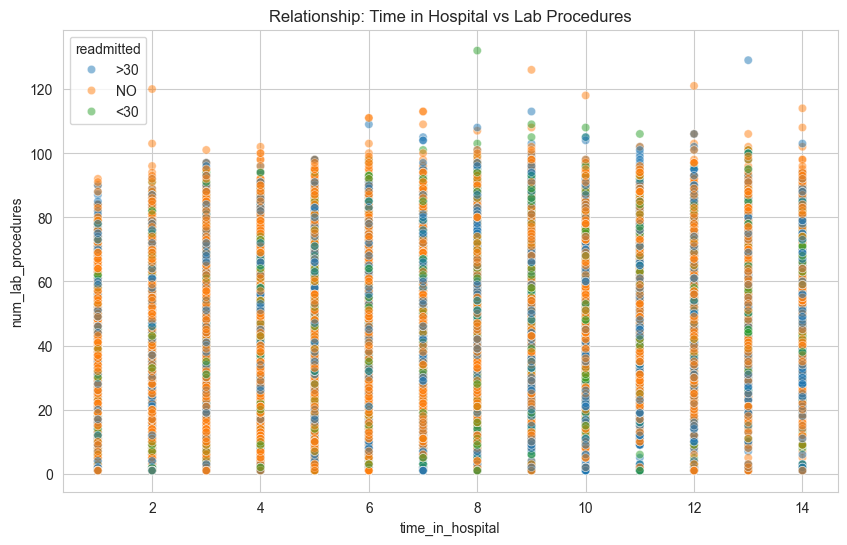

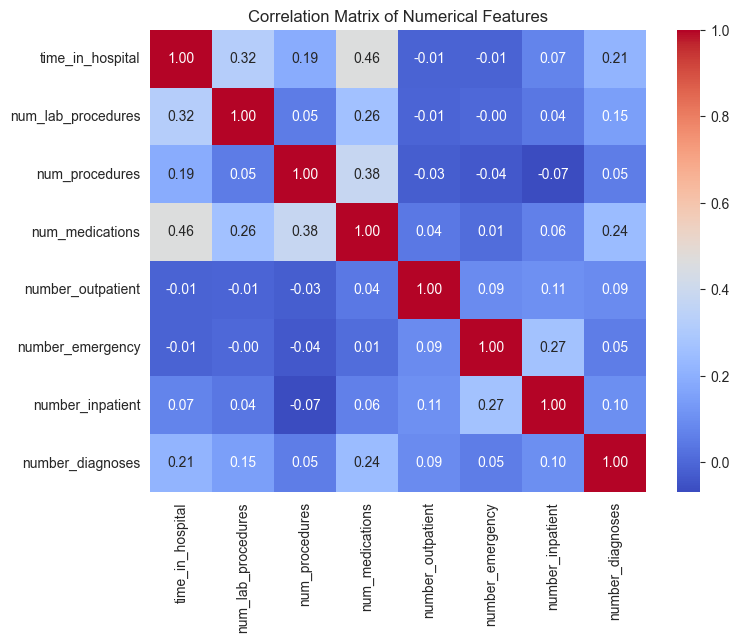

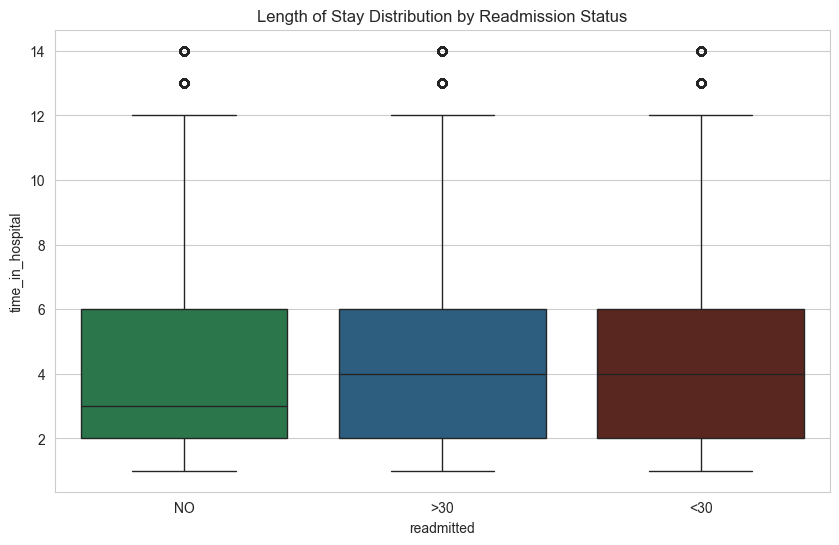

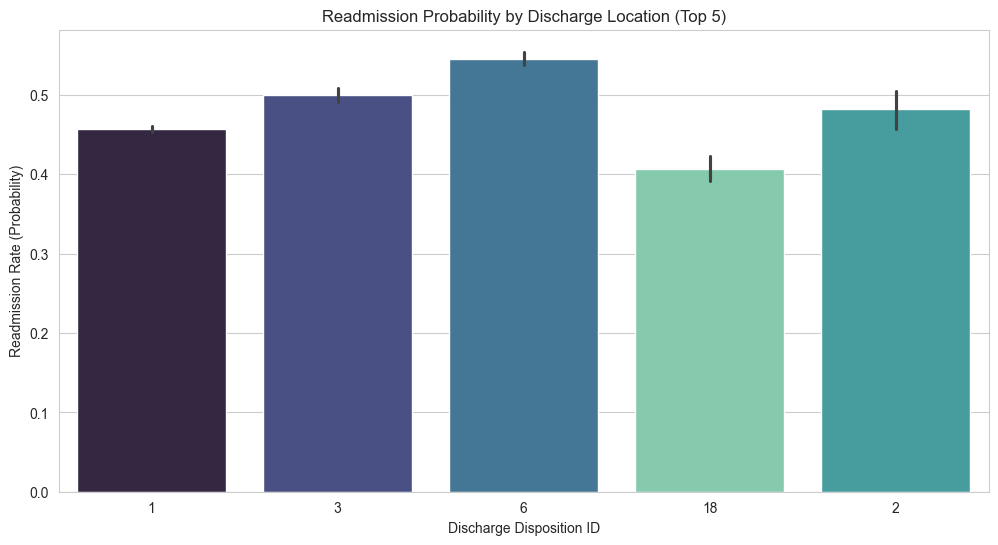

In [52]:
# Time in Hospital vs Lab Procedures
plt.figure(figsize=(10, 6))
# A scatter plot is generated to inspect the linearity between stay duration and lab usage.
sbns.scatterplot(
    x = 'time_in_hospital', 
    y = 'num_lab_procedures', 
    hue = 'readmitted', 
    data = diabetes_clinical_data,
    alpha = 0.5
)
#    palette='viridis'

plt.title("Relationship: Time in Hospital vs Lab Procedures")
plt.show()


# Correlation Heatmap
plt.figure(figsize=(8, 6))

operational_numeric_cols = [
    'time_in_hospital', 
    'num_lab_procedures', 
    'num_procedures', 
    'num_medications',
    'number_outpatient',
    'number_emergency',
    'number_inpatient',
    'number_diagnoses'
]

corr_matrix = diabetes_clinical_data[operational_numeric_cols].corr()

# A heatmap is used to identify multicollinearity (redundancy).
sbns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()


# Stay Duration by Readmission Status
plt.figure(figsize=(10, 6))

# Box plots allow for the comparison of medians and outlier distributions.
sbns.boxplot(
    x='readmitted', 
    y='time_in_hospital', 
    data=diabetes_clinical_data, 
    hue='readmitted',
    order=['NO', '>30', '<30'], 
    palette={
        'NO': '#1E8449',
        '>30': '#1F618D',
        '<30': '#641E16'
    }, 
)
plt.title("Length of Stay Distribution by Readmission Status")
plt.show()


# Discharge Disposition Analysis 
top_discharges = diabetes_clinical_data['discharge_disposition_id'].value_counts().head(5).index
filtered_discharge = diabetes_clinical_data[diabetes_clinical_data['discharge_disposition_id'].isin(top_discharges)]

plt.figure(figsize=(12, 6))
# We use a Bar Plot (Calculates Mean/Rate) instead of a Count Plot.
sbns.barplot(
    x='discharge_disposition_id', 
    y='has_readmission', 
    data=filtered_discharge, 
    hue='discharge_disposition_id',
    palette='mako',
    order=top_discharges,
    legend=False
)
plt.title("Readmission Probability by Discharge Location (Top 5)")
plt.ylabel("Readmission Rate (Probability)")
plt.xlabel("Discharge Disposition ID")
plt.show()

# Discharge Disposition Analysis (Rates vs Counts, Top 5 locations)
# # First, we identify the Top 5 most common discharge locations to keep the chart readable.
# top_discharges = clinical_df['discharge_disposition_id'].value_counts().head(5).index
# filtered_discharge = clinical_df[clinical_df['discharge_disposition_id'].isin(top_discharges)]

# plt.figure(figsize=(12, 6))
# sns.countplot(x='discharge_disposition_id', hue='readmitted', data=filtered_discharge, palette='viridis')
# plt.title("Readmission by Discharge Location (Top 5)")
# plt.legend(title='Readmitted')
# plt.show()

## **Phase 4: Feature Engineering - The "Vitality Complexity Index"**
to create a programmable risk classification algorithm based on clinical intuition. To identify high-risk patients, a simpler version of the LACE Index called the "Vitality Complexity Index" (VCI) was created.

**Algorithm Logic (VCI Calculation):**
1. **L (Length of Stay):**The resource burden of the index admission is captured by **L (Length of Stay).
2. **A (Acuity):** Recognizes trauma and urgent admissions, which are by nature more unstable.
3. **C (Comorbidities):** Employs the number of diagnoses as a stand-in for the burden of systemic illness.

4. **E (Emergency Visits):** Records the frequency of previous use of acute care.

**Validation Strategy:**
The calculated VCI Score is divided into three risk categories: Low (<7), Medium (7–10), and High (>10). The *actual* readmission rate (<30 days) for each stratum is determined in order to assess the model's validity.

In [ ]:
def calculate_L_score(days):
    """ L - Length of Stay Score """
    if days < 1: return 0
    elif 1 <= days <= 4: return 1
    elif 5 <= days <= 13: return 4
    else: return 7  # >= 14 days

def calculate_A_score(admission_id):
    """ A - Acuity of Admission Score (1=Emergency, 7=Trauma) """
    if admission_id in [1, 7]: return 3
    else: return 0

def calculate_C_score(num_diagnoses):
    """ C - Comorbidity Burden Score (Proxy: Count of Diagnoses) """
    if num_diagnoses < 4: return 0
    elif 4 <= num_diagnoses <= 7: return 3
    else: return 5  # >= 8 diagnoses

def calculate_E_score(num_visits):
    """ E - Emergency Visit Intensity Score """
    if num_visits == 0: return 0
    elif 1 <= num_visits <= 4: return 3
    else: return 5  # > 4 visits

# Apply Logic to Create Component Columns (Traceability)
print("Calculating VCI Components...")
diabetes_clinical_data['L_score'] = diabetes_clinical_data['time_in_hospital'].apply(calculate_L_score)
diabetes_clinical_data['A_score'] = diabetes_clinical_data['admission_type_id'].apply(calculate_A_score)
diabetes_clinical_data['C_score'] = diabetes_clinical_data['number_diagnoses'].apply(calculate_C_score)
diabetes_clinical_data['E_score'] = diabetes_clinical_data['number_emergency'].apply(calculate_E_score)

# Calculate Final VCI Score
# We sum the components. Since we have the columns, this is easy and verifiable.
diabetes_clinical_data['VCI_Score'] = (diabetes_clinical_data['L_score'] + 
                            diabetes_clinical_data['A_score'] + 
                            diabetes_clinical_data['C_score'] + 
                            diabetes_clinical_data['E_score'])

# Stratify Risk
def categorize_risk(score):
    if score < 7: return 'Low Risk'
    elif 7 <= score <= 10: return 'Medium Risk'
    else: return 'High Risk'

diabetes_clinical_data['Risk_Category'] = diabetes_clinical_data['VCI_Score'].apply(categorize_risk)

# Verification: Show the components and the total to prove it works
print("Feature Engineering Complete. Sample Check:")
diabetes_clinical_data[['L_score', 'A_score', 'C_score', 'E_score', 'VCI_Score', 'Risk_Category']].head(10)

Calculating VCI Components...
Feature Engineering Complete. Sample Check:


,L_score,A_score,C_score,E_score,VCI_Score,Risk_Category
0,1,0,5,0,6,Low Risk
1,1,0,3,0,4,Low Risk
2,1,0,3,0,4,Low Risk
3,1,0,3,0,4,Low Risk
4,1,0,5,0,6,Low Risk
5,1,0,3,0,4,Low Risk
6,4,0,5,0,9,Medium Risk
7,4,0,5,0,9,Medium Risk
8,4,0,5,0,9,Medium Risk
9,4,0,5,0,9,Medium Risk


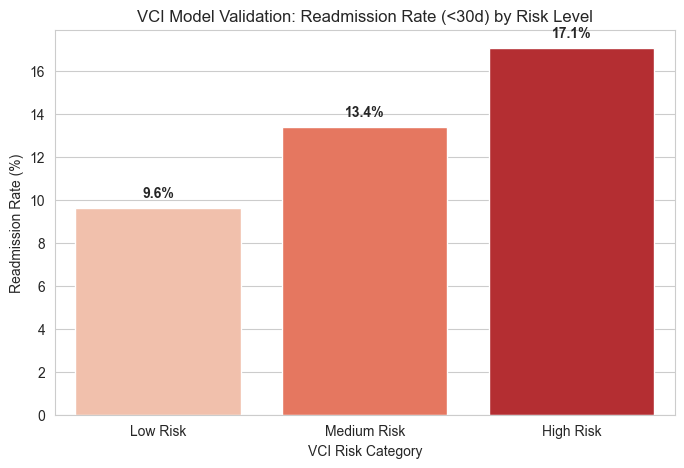

--- Validation Insight ---
Low Risk Readmission Rate:   9.62%
High Risk Readmission Rate:  17.05%
Algorithm Lift: High Risk patients are 1.8x more likely to return.


In [44]:
# --- Phase 4: Validation ---

# Create Target Flag (Strictly <30 days as per HRRP)
diabetes_clinical_data['is_readmitted_30'] = (diabetes_clinical_data['readmitted'] == '<30').astype(int)

# Calculate Readmission Rate per Risk Category
risk_validation = diabetes_clinical_data.groupby('Risk_Category')['is_readmitted_30'].mean() * 100

# Reorder for the chart (Low -> Med -> High)
risk_validation = risk_validation.reindex(['Low Risk', 'Medium Risk', 'High Risk'])

# Visualize
plt.figure(figsize=(8, 5))
sbns.barplot(
    x=risk_validation.index, 
    y=risk_validation.values, 
    hue=risk_validation.index ,
    palette='Reds', 
    legend=False 
)

plt.title("VCI Model Validation: Readmission Rate (<30d) by Risk Level")
plt.ylabel("Readmission Rate (%)")
plt.xlabel("VCI Risk Category")

# Add value labels on top of bars
for index, value in enumerate(risk_validation):
    plt.text(index, value + 0.5, f"{value:.1f}%", ha='center', fontweight='bold')

plt.show()

print("--- Validation Insight ---")
print(f"Low Risk Readmission Rate:   {risk_validation['Low Risk']:.2f}%")
print(f"High Risk Readmission Rate:  {risk_validation['High Risk']:.2f}%")
print(f"Algorithm Lift: High Risk patients are {risk_validation['High Risk']/risk_validation['Low Risk']:.1f}x more likely to return.")

In [46]:
# Save the final analytical dataset
diabetes_clinical_data.to_csv('./data/final_diabetes_analysis_VCI.csv', index=False)
print("Project Complete. Data exported successfully.")

Project Complete. Data exported successfully.
